## Images external to jupyter: %matplotlib notebook

In [1]:
import time

from diffractio import degrees, mm, um
from diffractio import np, plt
from diffractio.scalar_fields_X import (Scalar_field_X,
                                        extended_polychromatic_source,
                                        extended_source_multiprocessing,
                                        polychromatic_multiprocessing)
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.utils_multiprocessing import (_pickle_method, _unpickle_method,
                                              execute_multiprocessing)
from multiprocessing import Pool
from diffractio.utils_optics import (gauss_spectrum, lorentz_spectrum,
                                     uniform_spectrum)

from diffractio.scalar_fields_XZ import Scalar_field_XZ

from diffractio import degrees, mm, plt, sp, um, np

from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_masks_XZ import Scalar_mask_XZ


In [6]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 250


## image in an external window

In [7]:
x0 = np.linspace(-200 * um, 200 * um, 512)
z0 = np.linspace(-100 * um, 600 * um, 512 * 4)
wavelength = 10 * um
u0 = Scalar_source_X(x=x0, wavelength=wavelength)
u0.plane_wave(A=1, theta=0 * degrees)
u1 = Scalar_mask_XZ(x=x0, z=z0, wavelength=wavelength)
u1.incident_field(u0)
focal, _ = u1.lens_convergent(r0=(0, 0),
                              aperture=300 * um,
                              radius=(1000 * um, -250 * um),
                              thickness=100 * um,
                              refraction_index=2,
                              angle=0 * degrees,
                              mask=(10 * um, 3 + 5j))
u1.clear_field()

192.30769230769232


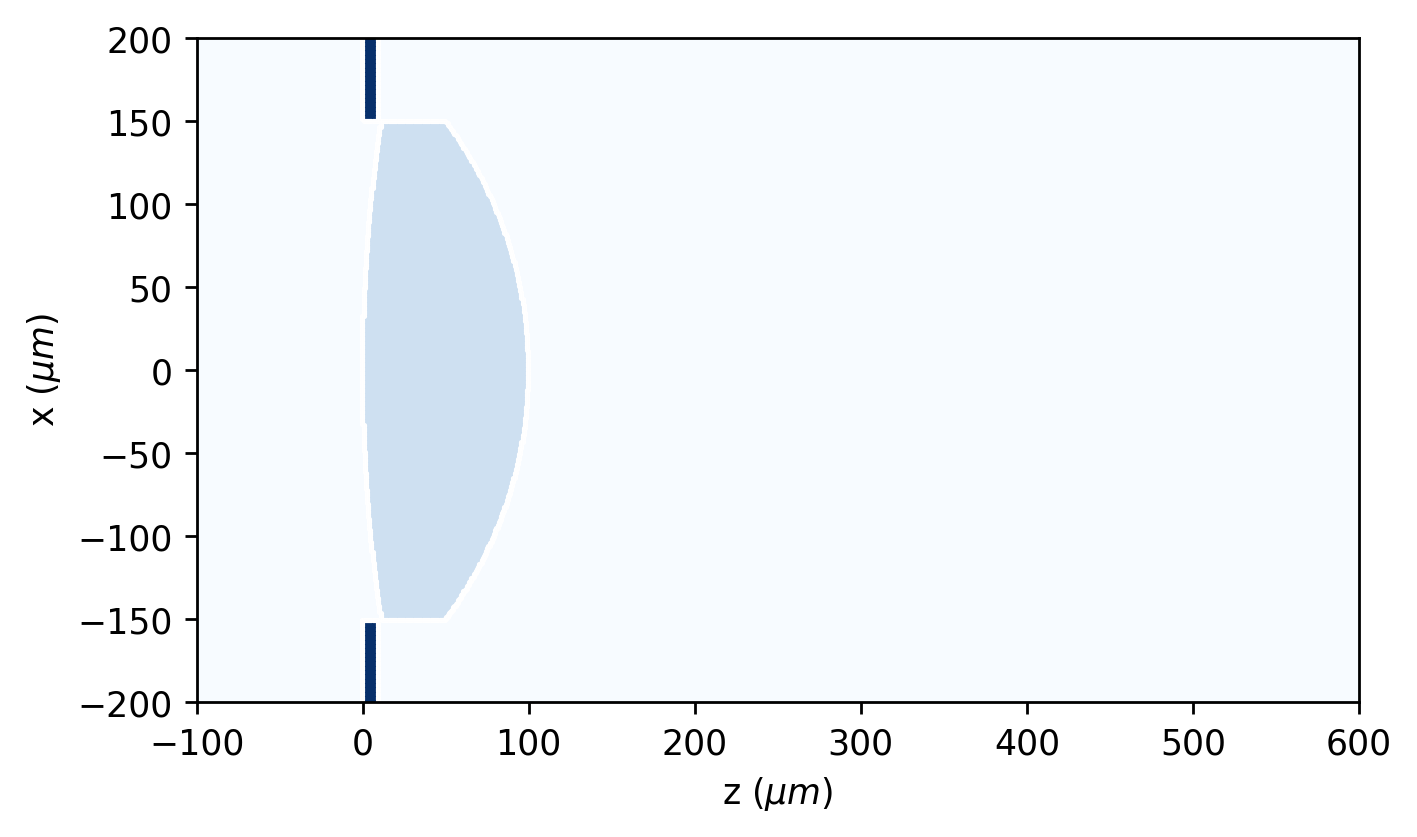

In [8]:
print(focal)
u1.draw_refraction_index(scale='scaled')
edge_matrix = u1.borders


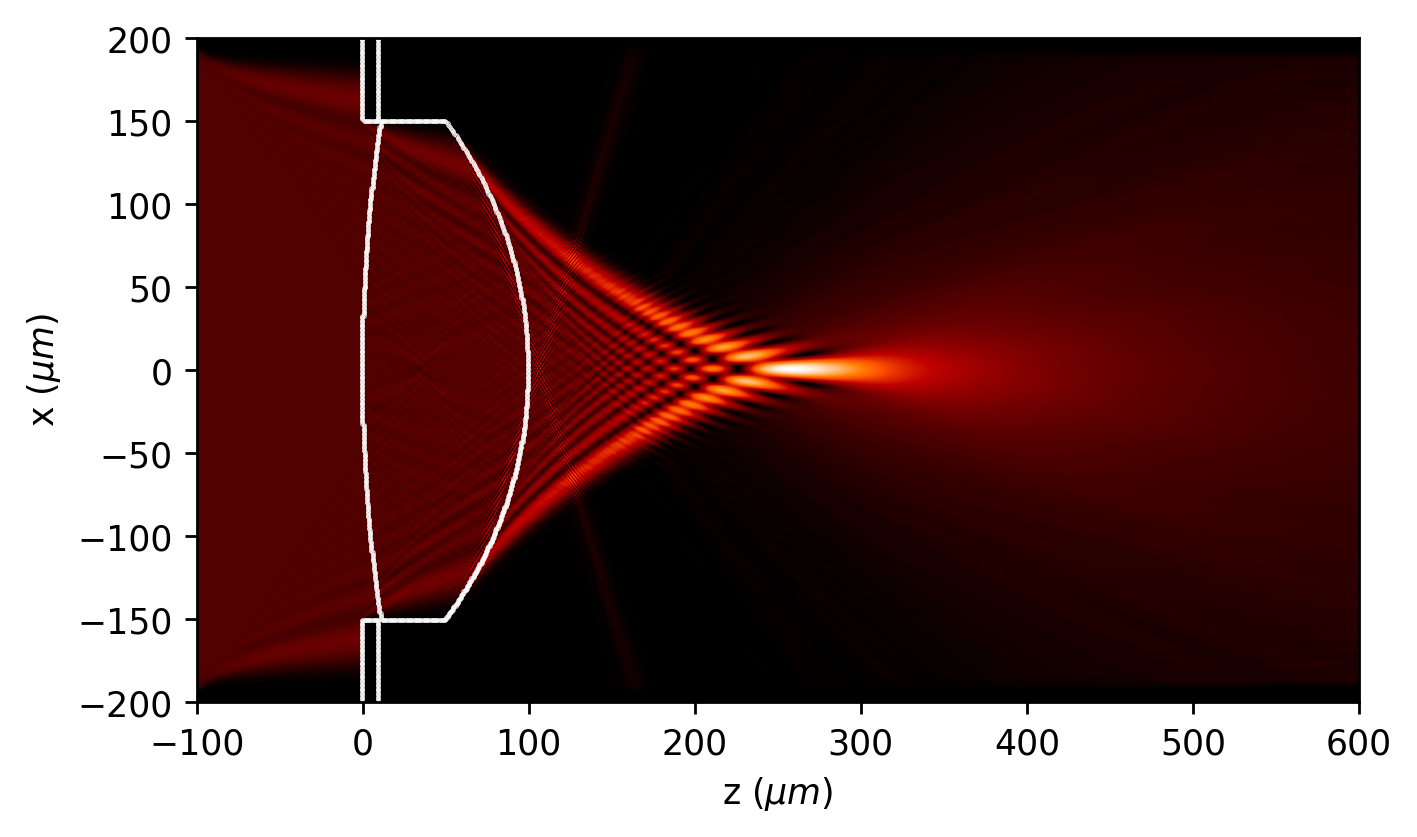

In [9]:
u1.BPM(verbose=False)
u1.draw(logarithm=True, normalize='maximum', draw_borders=True, scale='scaled')


Now in external window

In [10]:
%matplotlib qt

In [11]:
u1.draw(logarithm=True, normalize='maximum', draw_borders=True, scale='scaled')


In [12]:
# Recovering inline
%matplotlib inline 


rcParams['figure.dpi']=250

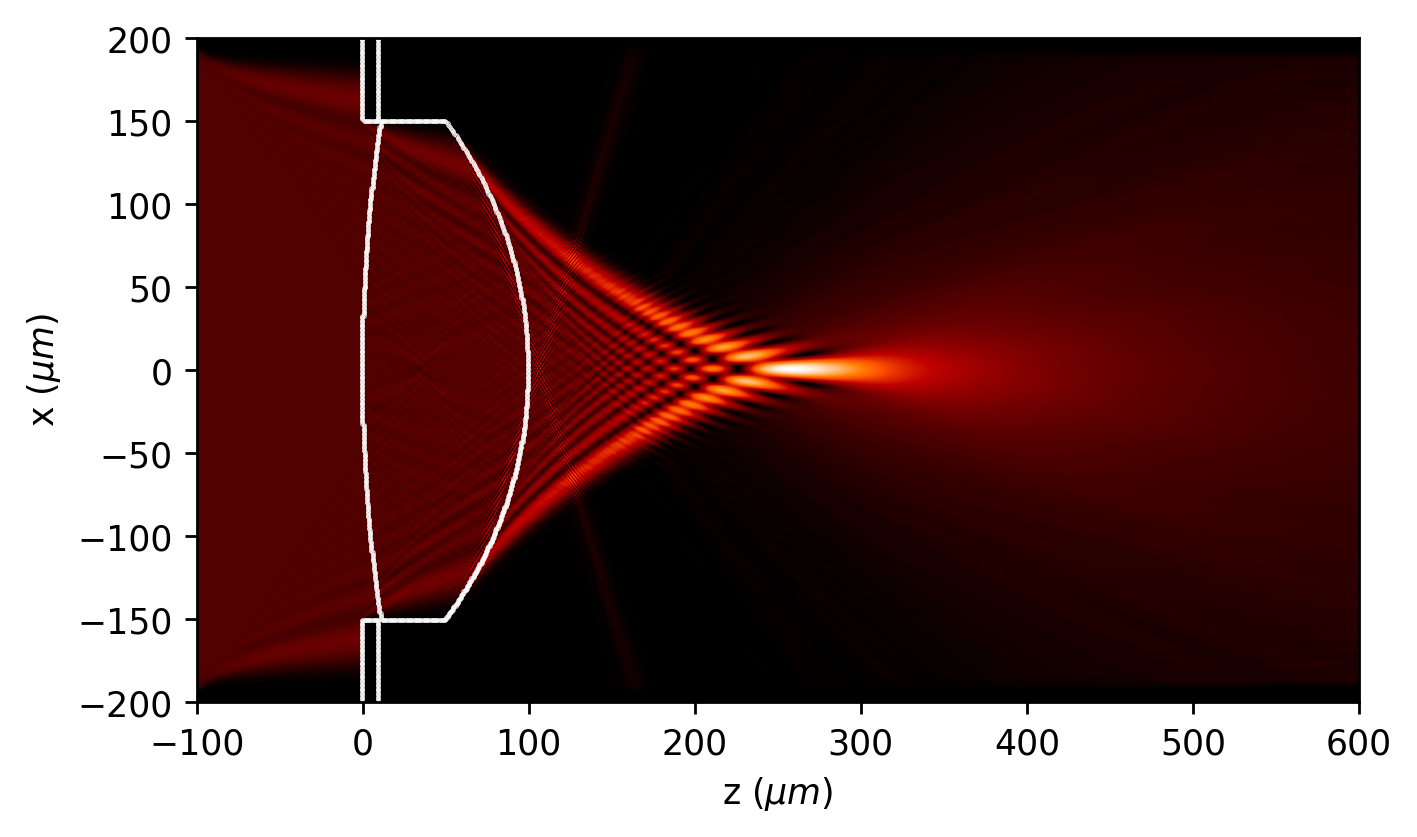

In [13]:
u1.draw(logarithm=True, normalize='maximum', draw_borders=True, scale='scaled')


### simulation of a video

In [14]:
def __experiment_grating_movement__(dict_params):
    delta_x = dict_params['delta_x']
    period = dict_params['period']
    t1 = dict_params['t1']
    t2 = dict_params['t2']
    t2.ronchi_grating(period=period, x0=delta_x, fill_factor=0.5)
    u2 = t1 * t2
    return u2

In [15]:
def creation_dictionary(deltas_x, period, t1, t2):
    # create Parameters: for multiprocessing
    dict_Parameters = []
    for i, delta_x in enumerate(deltas_x):
        dict_Parameters.append(
            dict(delta_x=delta_x, period=period, t1=t1, t2=t2))
    return dict_Parameters

In [16]:
x0 = np.linspace(-400 * um, 400 * um, 1024 * 2)
wavelength = 0.85 * um
period = 50 * um
z_talbot = 2 * period**2 / wavelength
z0 = z_talbot / 2
delay = 0.001

t1 = Scalar_mask_X(x0, wavelength, info="__experiment_grating_movement__")
t1.ronchi_grating(period=period, x0=0 * um, fill_factor=0.5)
t1.RS(z=z0, new_field=False)

t2 = Scalar_mask_X(x0, wavelength, info="__experiment_grating_movement__")
t2.ronchi_grating(period=period, x0=0 * um, fill_factor=0.5)

deltas_x = np.linspace(-60 * um, 60 * um, 128)  # 512

dict_Parameters = creation_dictionary(deltas_x=deltas_x,
                                      period=period,
                                      t1=t1,
                                      t2=t2)

u_s, time_proc = execute_multiprocessing(__experiment_grating_movement__,
                                         dict_Parameters,
                                         num_processors=1,
                                         verbose=True)

x = u_s[0].x


Good result: factor 11.33
num_proc: 1, time=0.035590410232543945


In [17]:
%matplotlib qt

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

perfil = np.zeros_like(deltas_x)

h1, = ax1.plot(x, np.zeros_like(x), 'k', lw=2)
ax1.set_xlim(x[0], x[-1])
ax1.set_ylim(0, 2)
ax1.set_xlabel(r'$x (\mu m)$')

h2, = ax2.plot(deltas_x, perfil, 'k', lw=2)
ax2.set_xlim(deltas_x[0], deltas_x[-1])
ax2.set_ylim(0, .5)
ax2.set_xlabel(r'$\Delta x (\mu m)$')

incr_frames = 1
for i in range(0, len(deltas_x), incr_frames):
    intensidad = abs(u_s[i].u)**2  # sacar fuera
    perfil[i] = intensidad.mean()
    plt.suptitle(r"$\delta x={:6.2f}\,\mu m$".format(deltas_x[i]), fontsize=18)
    h1.set_ydata(intensidad)
    h2.set_ydata(perfil)
    plt.draw()
    plt.pause(0.005)